In [1]:
from pathlib import Path
import pandas as pd

# vot_measured/vot_f0_results.txt 파일에서 모든 나이대 데이터 로드
base_dir = Path.cwd() / "vot_measured"
file_path = base_dir / "vot_f0_results.txt"

df = pd.read_csv(
    file_path,
    sep="\t",                  # 파일이 탭 구분자
    na_values=["--undefined--"]
)

# 'pp prevoicing', 'tt prevoicing', 'prevoicing', 'oo' row는 애초에 제거
df = df[df["label"] != "pp prevoicing"].reset_index(drop=True)
df = df[df["label"] != "tt prevoicing"].reset_index(drop=True)
df = df[df["label"] != "prevoicing"].reset_index(drop=True)
df = df[df["label"] != "oo"].reset_index(drop=True)

# edge_cases를 정상 자음으로 변환
edge_case_map = {
    "ph fricative-like start": "ph",
    "po": "p",
    "pp?": "pp",
    "ph?": "ph",
    "k?": "k",
    "tt?": "tt",
    "kh?": "kh",
    "kk?": "kk",
    "pp? no VOT?": "pp",
    "k fricative-like": "k",
    "k released": "k",
    "kh fricative-like": "kh",
    "p voiced": "p",
}
df["label"] = df["label"].replace(edge_case_map)

# 숫자 컬럼들은 확실히 float로 변환(undef 처리 포함)
numeric_cols = [
    "VOT",
    "f0",
    "f0_5ms_after_onset",
    "F1_midpoint",
    "F2_midpoint",
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# age_group 컬럼이 이미 있으면 그대로, 없으면 생성 필요
if "age_group" not in df.columns:
    # age 컬럼이 있으면 age_group 생성
    if "age" in df.columns:
        df["age_group"] = df["age"].apply(lambda x: f"{int(x // 10) * 10}s" if pd.notnull(x) else None)

# 자음-모음+받침 row 병합 (sliding window 방식, 2개 또는 3개 묶음 처리)
valid_consonants = {"t", "p", "k", "tt", "pp", "kk", "kh", "th", "ph"}
unique_korean_words_romanized = [
    'pi', 'nan', 'nos', 'os', 'ppok', 'ssi', 'tan', 'mam', 'kak', 'mang', 'kkong', 'ppi', 'cas', 'kkak', 'hak', 'khok', 'ttok', 'pok', 'sol', 'nal', 'chak', 'khan', 'mom', 'ttong', 'thong', 'chok', 'man', 'ti', 'am', 'khi', 'an', 'son', 'ak', 'nom', 'al', 'nok', 'nak', 'tok', 'nas', 'mal', 'kan', 'com', 'hon', 'chon', 'ttak', 'thak', 'hok', 'tti', 'i', 'phi', 'thi', 'phak', 'khak', 'nong', 'ki', 'kim', 'phan', 'nap', 'si', 'thok', 'mas', 'kkok', 'pan', 'ppong', 'ok', 'mos', 'than', 'cim', 'kkan', 'tong', 'phong', 'som', 'ttan', 'tak', 'pong', 'kok', 'mak', 'phok', 'kki', 'mi', 'sok', 'non', 'mok', 'chim', 'nam', 'him', 'nim', 'pak', 'ppan', 'ppak', 'soth', 'aph', 'kong'
 ]

In [2]:

merged_rows = []
i = 0
while i < len(df):
    # 3개 묶음: row1+row2+row3가 unique_korean_words_romanized에 있으면 병합
    if i + 2 < len(df):
        row1 = df.iloc[i]
        row2 = df.iloc[i+1]
        row3 = df.iloc[i+2]
        combined = row1["label"] + row2["label"] + row3["label"]
        if (row1["filename"] == row2["filename"] == row3["filename"] and combined in unique_korean_words_romanized):
            merged_rows.append({
                "filename": row1["filename"],
                "consonant": row1["label"],
                "rest": row2["label"] + row3["label"],
                "f0": row2.get("f0_5ms_plus_more_after_onset", None),  # rest의 f0 사용
                "VOT": row1["duration"] * 1000,  # s → ms
                "rest_duration": (row2["duration"] + row3["duration"]) * 1000,  # s → ms
            })
            i += 3
            continue
    # 일반적인 2개 묶음 처리
    if i + 1 < len(df):
        row1 = df.iloc[i]
        row2 = df.iloc[i+1]
        if row1["filename"] == row2["filename"]:
            merged_rows.append({
                "filename": row1["filename"],
                "consonant": row1["label"],
                "rest": row2["label"],
                "f0": row2.get("f0_5ms_plus_more_after_onset", None),  # rest의 f0 사용
                "VOT": row1["duration"] * 1000,  # s → ms
                "rest_duration": row2["duration"] * 1000,  # s → ms
            })
            i += 2
            continue
    i += 1

merged_df = pd.DataFrame(merged_rows)

# 병합된 데이터에서 consonant 값 체크
invalid_rows = merged_df[~merged_df["consonant"].isin(valid_consonants)]

In [3]:
import re

def extract_ids(filename):
    # proliferate_id-worker_id-session_number
    m = re.match(r"^(\d+)-(\d+)-(\d+)", str(filename))
    if m:
        return m.group(1), m.group(3)
    # proliferate_id-session_number
    m = re.match(r"^(\d+)-(\d+)", str(filename))
    if m:
        return m.group(1), m.group(2)
    return None, None

# filename에서 id 추출
merged_df['prolific_id'], merged_df['session_number'] = zip(*merged_df['filename'].map(extract_ids))
merged_df.head()

,filename,consonant,rest,f0,VOT,rest_duration,prolific_id,session_number
0,201-1,kk,i#,264.2056518329895,29.886215,223.518167,201,1
1,201-1,tt,ak,245.41529357337814,13.525962,208.456056,201,1
2,201-1,k,ok,233.4093673665817,70.244628,152.300629,201,1
3,201-1,k,i#,216.3601689259274,92.745353,285.581885,201,1
4,201-1,t,ok,224.79747879144438,55.000000,157.544385,201,1


In [4]:
# perception: prolific_participant_id와 age, gender 매핑 만들기
perception_subject_df = pd.read_csv(r'C:\Users\hanpe\github\korean-stops\analysis\perception\data\korean_stops_perception_3_poa_all_ages-subject_information.csv', dtype=str)
perception_workerids_df = pd.read_csv(r'C:\Users\hanpe\github\korean-stops\analysis\perception\data\korean_stops_perception_3_poa_all_ages-workerids.csv', dtype=str)

# perception workerid → prolific_participant_id
perception_workerid_to_prolific = dict(zip(perception_workerids_df['workerid'], perception_workerids_df['prolific_participant_id']))

# prolific_participant_id → age, gender
prolific_to_age = {}
prolific_to_gender = {}
for idx, row in perception_subject_df.iterrows():
    workerid = row['workerid']
    age = row['age']
    gender = row['gender'] if 'gender' in row else None
    prolific_id = perception_workerid_to_prolific.get(workerid, None)
    if prolific_id is not None:
        prolific_to_age[prolific_id] = age
        prolific_to_gender[prolific_id] = gender

# merged_df에 prolific_participant_id로 age, gender 추가
ages = []
genders = []
no_age = {}
for idx, row in merged_df.iterrows():
    prolific_id = str(row['prolific_id'])
    age = prolific_to_age.get(prolific_id, None)
    gender = prolific_to_gender.get(prolific_id, None)
    # post processing
    if age == '196707':
        age = str(2025 - 1967)
    elif age == '-59':
        age = '59'
    # None인 경우 prolific_id로 추정
    if age is None and pd.notnull(row['prolific_id']):
        if prolific_id not in no_age:
            no_age[prolific_id] = True
            print(f"Participant [{row['prolific_id']}] has no age")
        try:
            decade = int(str(row['prolific_id'])[0])
            if 2 <= decade <= 9:
                age = str(decade * 10 + 5)
        except Exception:
            age = None
    ages.append(age)
    genders.append(gender)
merged_df['age'] = ages
merged_df['gender'] = genders

merged_df.head()

Participant [606] has no age
Participant [607] has no age
Participant [625] has no age


,filename,consonant,rest,f0,VOT,rest_duration,prolific_id,session_number,age,gender
0,201-1,kk,i#,264.2056518329895,29.886215,223.518167,201,1,28,Female
1,201-1,tt,ak,245.41529357337814,13.525962,208.456056,201,1,28,Female
2,201-1,k,ok,233.4093673665817,70.244628,152.300629,201,1,28,Female
3,201-1,k,i#,216.3601689259274,92.745353,285.581885,201,1,28,Female
4,201-1,t,ok,224.79747879144438,55.000000,157.544385,201,1,28,Female


In [5]:
len(merged_df)

6934

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
sns.set_palette("husl")

df_clean = merged_df.rename(columns={
    'consonant': 'label',
    'VOT' : "vot",
})

# f0, vot 컬럼을 명시적으로 float으로 변환
df_clean['f0'] = pd.to_numeric(df_clean['f0'], errors='coerce')
df_clean['vot'] = pd.to_numeric(df_clean['vot'], errors='coerce')
df_clean['age'] = pd.to_numeric(df_clean['age'], errors='coerce')

In [7]:
# df_clean = df_clean[df_clean['filename'] == "201-1"]

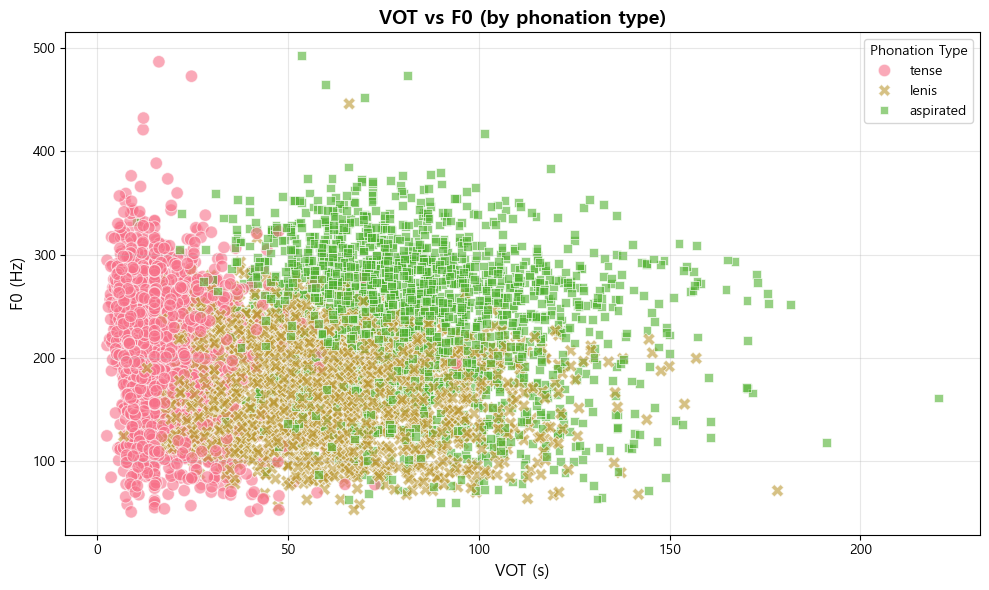


Stop consonant data: 6934 rows
VOT range: 2.5 ~ 220.5 ms
F0 range: 51 ~ 493 Hz
Scaled VOT range: 0.005 ~ 1.703
Normalized F0 range: -6.056 ~ 7.003


In [8]:
# 1. VOT vs F0 scatter plot (by phonation type only)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Filter stops only (exclude vowels)
stops_df = df_clean[~df_clean['label'].isin(['a', 'i', 'o'])].copy()

# 참가자별로 f0 정규화 (z-score)
stops_df['normed_f0'] = stops_df.groupby('prolific_id')['f0'].transform(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0)

# stops_df에 scaled_vot 컬럼 추가
stops_df['scaled_vot'] = stops_df['vot'] / stops_df['rest_duration']

# Classify by phonation type only
stops_df['phonation'] = stops_df['label'].map({
    'k': 'lenis', 'kk': 'tense', 'kh': 'aspirated',
    't': 'lenis', 'tt': 'tense', 'th': 'aspirated',
    'p': 'lenis', 'pp': 'tense', 'ph': 'aspirated',
})

# Scatter plot by phonation type
sns.scatterplot(data=stops_df, x='vot', y='f0', hue='phonation', 
                style='phonation', s=80, alpha=0.6, ax=ax)
ax.set_title('VOT vs F0 (by phonation type)', fontsize=14, fontweight='bold')
ax.set_xlabel('VOT (s)', fontsize=12)
ax.set_ylabel('F0 (Hz)', fontsize=12)
ax.legend(title='Phonation Type', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStop consonant data: {len(stops_df)} rows")
print(f"VOT range: {stops_df['vot'].min():.1f} ~ {stops_df['vot'].max():.1f} ms")
print(f"F0 range: {stops_df['f0'].min():.0f} ~ {stops_df['f0'].max():.0f} Hz")
print(f"Scaled VOT range: {stops_df['scaled_vot'].min():.3f} ~ {stops_df['scaled_vot'].max():.3f}")
print(f"Normalized F0 range: {stops_df['normed_f0'].min():.3f} ~ {stops_df['normed_f0'].max():.3f}")

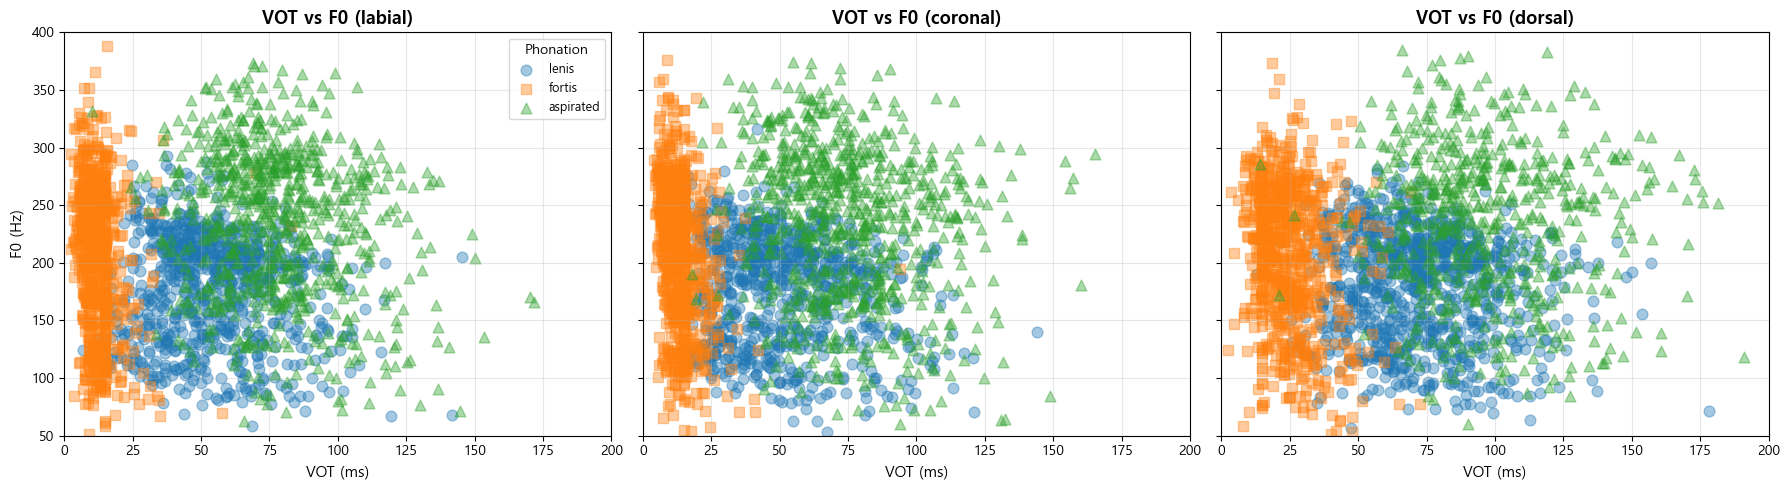

In [56]:
# POA별로 데이터 쪼개서 3개 그래프 (labial, coronal, dorsal 순)
POA = {
    "dorsal" : ["k", "kh", "kk"],
    "coronal" : ["t", "th", "tt"],
    "labial" : ["p", "ph", "pp"]
}

poa_map = {}
for poa, labels in POA.items():
    for l in labels:
        poa_map[l] = poa
stops_df['poa'] = stops_df['label'].map(poa_map)

# 일관된 phonation 순서, 색상, 마커
phonation_order = ['lenis', 'tense', 'aspirated']
colors = {'lenis': '#1f77b4', 'tense': '#ff7f0e', 'aspirated': '#2ca02c'}
markers = {'lenis': 'o', 'tense': 's', 'aspirated': '^'}
label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}

# 전체 vot, f0 범위 계산
vot_min, vot_max = stops_df['vot'].min(), stops_df['vot'].max()
f0_min, f0_max = stops_df['f0'].min(), stops_df['f0'].max()
vot_range = vot_max - vot_min
f0_range = f0_max - f0_min
vot_padding = vot_range * 0.05
f0_padding = f0_range * 0.05

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
poa_order = ['labial', 'coronal', 'dorsal']
for idx, poa in enumerate(poa_order):
    df_poa = stops_df[stops_df['poa'] == poa]
    for phonation in phonation_order:
        df_phon = df_poa[df_poa['phonation'] == phonation]
        axes[idx].scatter(df_phon['vot'], df_phon['f0'],
                         c=colors[phonation], marker=markers[phonation],
                         s=60, alpha=0.4, label=label_map[phonation] if idx==0 else None)
    axes[idx].set_title(f'VOT vs F0 ({poa})', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('VOT (ms)', fontsize=11)
    axes[idx].set_xlim(0, 200)
    axes[idx].set_ylim(50, 400)
    if idx == 0:
        axes[idx].set_ylabel('F0 (Hz)', fontsize=11)
    else:
        axes[idx].set_ylabel('')
    if idx == 0:
        axes[idx].legend(title='Phonation', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("x-vot-y-f0-by-poa.png", dpi=300, bbox_inches='tight')
plt.show()

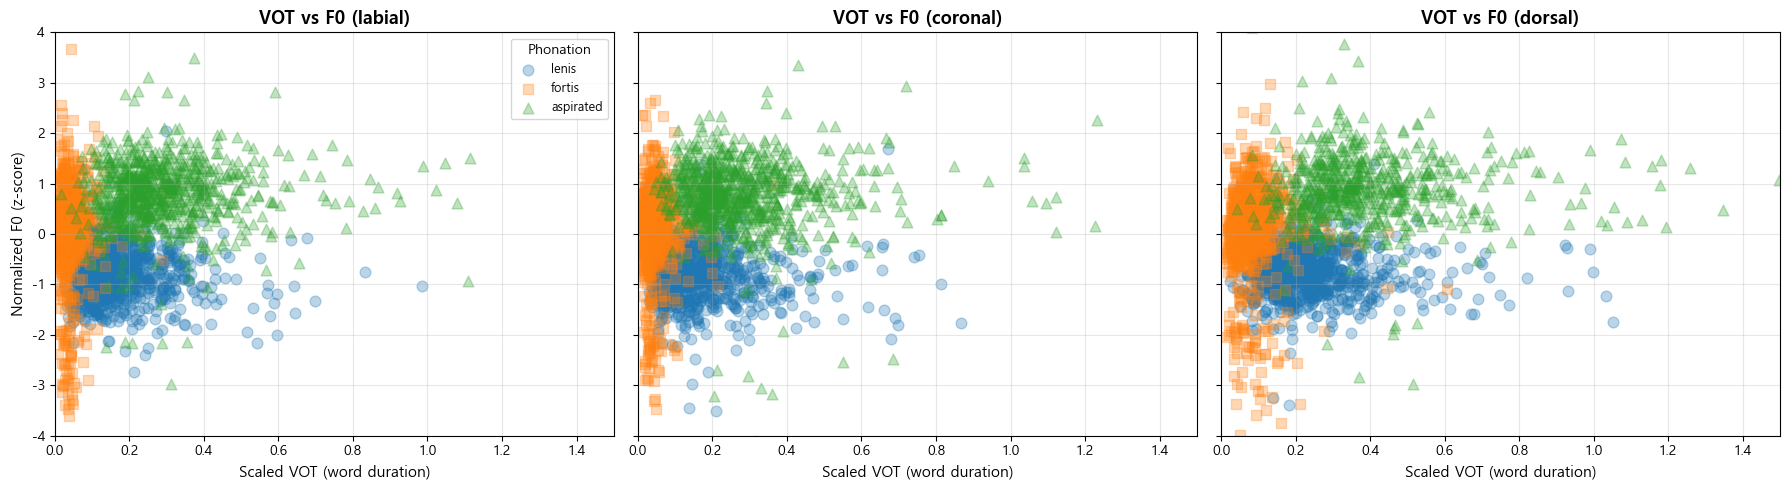

In [57]:
# POA별로 데이터 쪼개서 3개 그래프 (labial, coronal, dorsal 순) - normed f0, scaled vot
POA = {
    "dorsal" : ["k", "kh", "kk"],
    "coronal" : ["t", "th", "tt"],
    "labial" : ["p", "ph", "pp"]
}

poa_map = {}
for poa, labels in POA.items():
    for l in labels:
        poa_map[l] = poa
stops_df['poa'] = stops_df['label'].map(poa_map)

# 일관된 phonation 순서, 색상, 마커
phonation_order = ['lenis', 'tense', 'aspirated']
colors = {'lenis': '#1f77b4', 'tense': '#ff7f0e', 'aspirated': '#2ca02c'}
markers = {'lenis': 'o', 'tense': 's', 'aspirated': '^'}
label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}

# 전체 vot, f0 범위 계산
vot_min, vot_max = stops_df['scaled_vot'].min(), stops_df['scaled_vot'].max()
f0_min, f0_max = stops_df['normed_f0'].min(), stops_df['normed_f0'].max()
vot_range = vot_max - vot_min
f0_range = f0_max - f0_min
vot_padding = vot_range * 0.05
f0_padding = f0_range * 0.05

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
poa_order = ['labial', 'coronal', 'dorsal']
for idx, poa in enumerate(poa_order):
    df_poa = stops_df[stops_df['poa'] == poa]
    for phonation in phonation_order:
        df_phon = df_poa[df_poa['phonation'] == phonation]
        axes[idx].scatter(df_phon['scaled_vot'], df_phon['normed_f0'],
                         c=colors[phonation], marker=markers[phonation],
                         s=60, alpha=0.3, label=label_map[phonation] if idx==0 else None)
    axes[idx].set_title(f'VOT vs F0 ({poa})', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Scaled VOT (word duration)', fontsize=11)
    axes[idx].set_xlim(0, 1.5)
    axes[idx].set_ylim(-4, 4)
    if idx == 0:
        axes[idx].set_ylabel('Normalized F0 (z-score)', fontsize=11)
    else:
        axes[idx].set_ylabel('')
    if idx == 0:
        axes[idx].legend(title='Phonation', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("x-scaled-vot-y-normed-f0-by-poa.png", dpi=300, bbox_inches='tight')
plt.show()

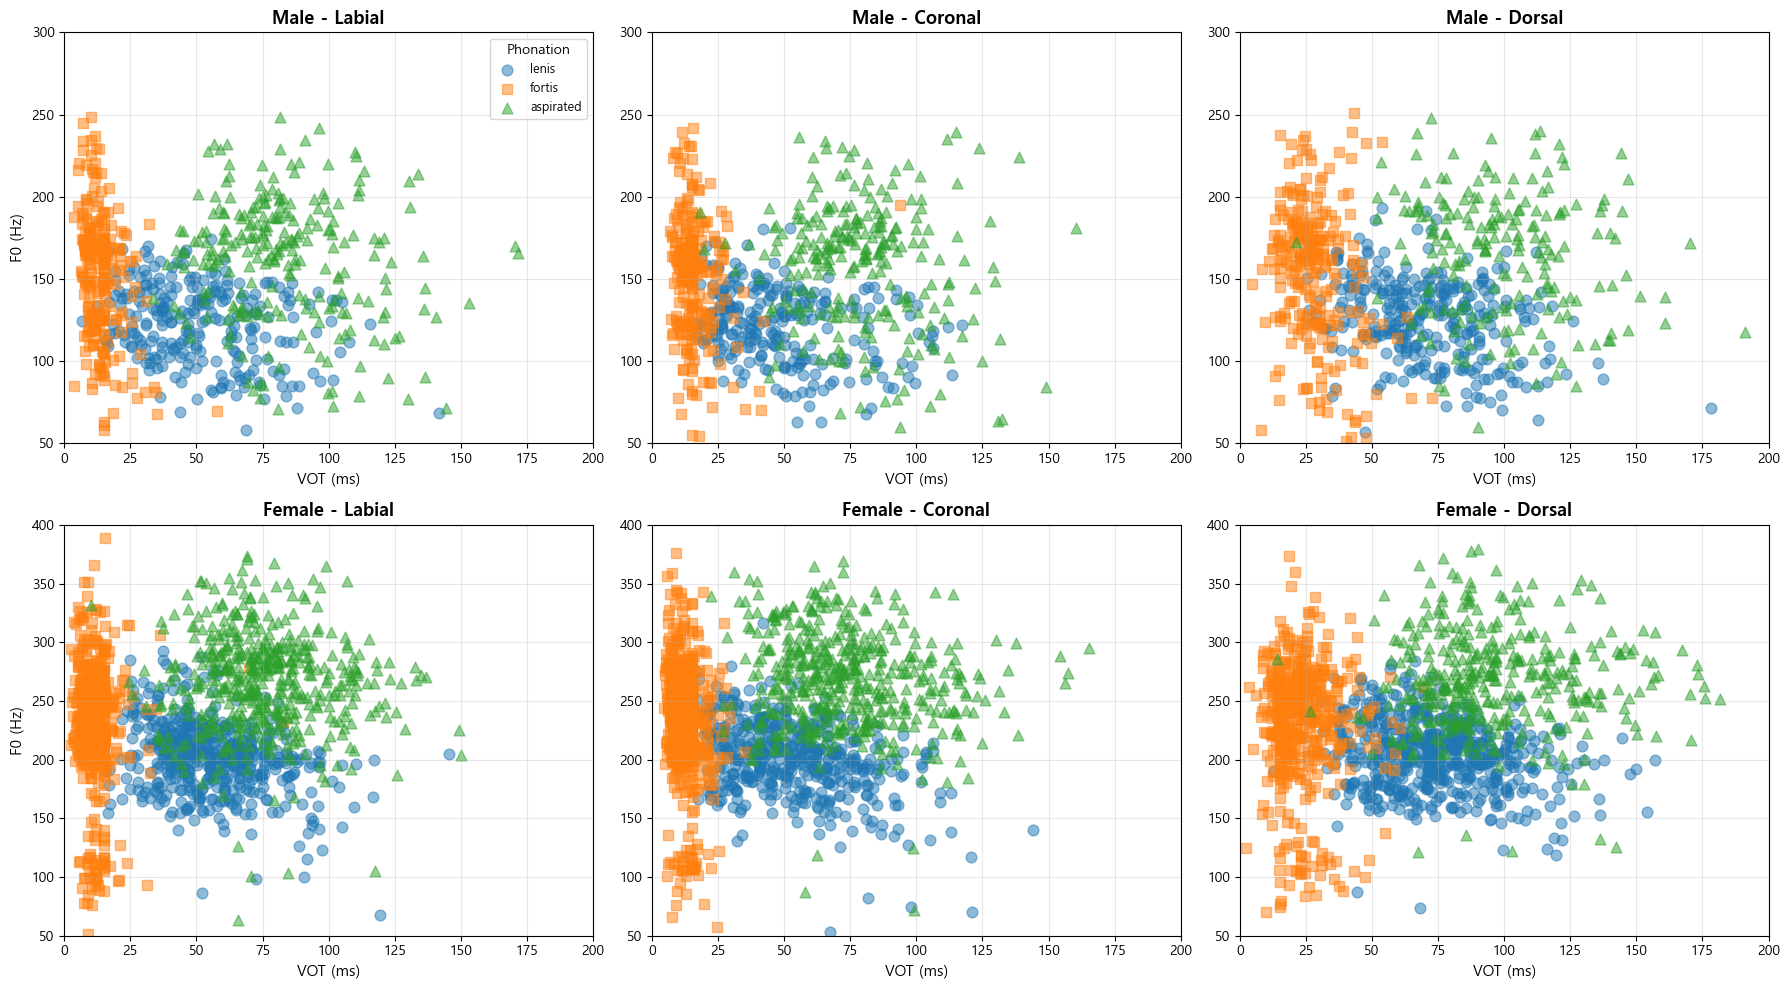

In [58]:
# POA + gender별 6개 그래프 (남/여가 행, POA가 열)
poa_order = ['labial', 'coronal', 'dorsal']  # POA별 열
gender_order = ['Male', 'Female']  # 남/여가 행
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)  # 2행 3열

for i, gender in enumerate(gender_order):
    for j, poa in enumerate(poa_order):
        df_sub = stops_df[(stops_df['poa'] == poa) & (stops_df['gender'] == gender)]
        for phonation in phonation_order:
            df_phon = df_sub[df_sub['phonation'] == phonation]
            axes[i, j].scatter(df_phon['vot'], df_phon['f0'],
                              c=colors[phonation], marker=markers[phonation],
                              s=60, alpha=0.5, label=label_map[phonation] if (i==0 and j==0) else None)
        axes[i, j].set_title(f'{gender} - {poa.capitalize()}', fontsize=13, fontweight='bold')
        axes[i, j].set_xlabel('VOT (ms)', fontsize=11)
        axes[i, j].set_xlim(0, 200)  # VOT 범위 제한
        if gender == 'Male':
            axes[i, j].set_ylim(50, 300)  # 남자 f0 범위 제한
        else:
            axes[i, j].set_ylim(50, 400)  # 여자 f0 범위 제한
        if j == 0:
            axes[i, j].set_ylabel('F0 (Hz)', fontsize=11)
        else:
            axes[i, j].set_ylabel('')
        if i == 0 and j == 0:
            axes[i, j].legend(title='Phonation', fontsize=9)
        axes[i, j].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("x-vot-y-f0-by-poa-and-gender.png", dpi=300, bbox_inches='tight')
plt.show()

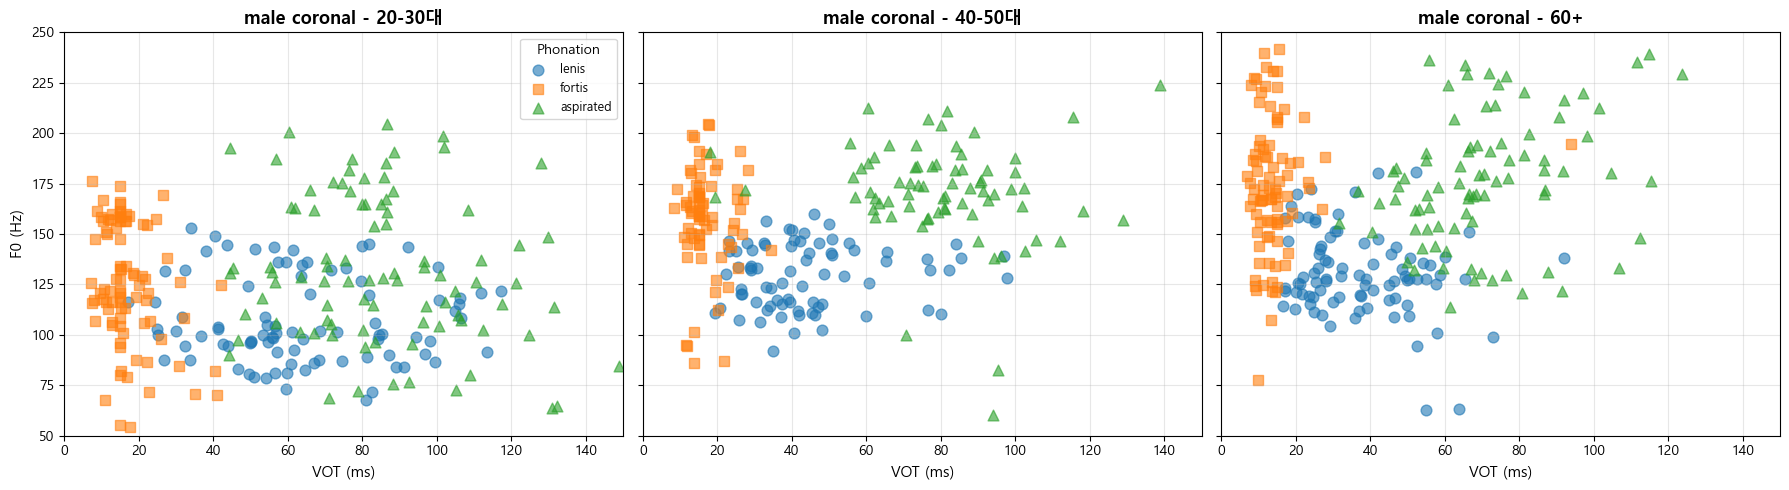

In [ ]:
# male coronal의 경우 3가지 나이대(20-30대, 40-50대, 60+)별로 그래프
# age가 str일 수 있으니 float으로 변환
stops_df['age'] = pd.to_numeric(stops_df['age'], errors='coerce')
age_bins = [0, 39, 59, 120]
age_labels = ['20-30대', '40-50대', '60+']
stops_df['age_group'] = pd.cut(stops_df['age'], bins=age_bins, labels=age_labels, right=True)

male_coronal = stops_df[(stops_df['poa'] == 'coronal') & (stops_df['gender'] == 'Male')]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, age_group in enumerate(age_labels):
    df_age = male_coronal[male_coronal['age_group'] == age_group]
    for phonation in phonation_order:
        df_phon = df_age[df_age['phonation'] == phonation]
        axes[idx].scatter(df_phon['vot'], df_phon['f0'],
                         c=colors[phonation], marker=markers[phonation],
                         s=60, alpha=0.6, label=label_map[phonation] if idx==0 else None)
    axes[idx].set_title(f'male coronal - {age_group}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('VOT (ms)', fontsize=11)
    axes[idx].set_xlim(0, 150)
    axes[idx].set_ylim(50, 250)

    if idx == 0:
        axes[idx].set_ylabel('F0 (Hz)', fontsize=11)
    else:
        axes[idx].set_ylabel('')
    if idx == 0:
        axes[idx].legend(title='Phonation', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Age group 20s-30s: 4790 observations

Age group 60s: 2144 observations


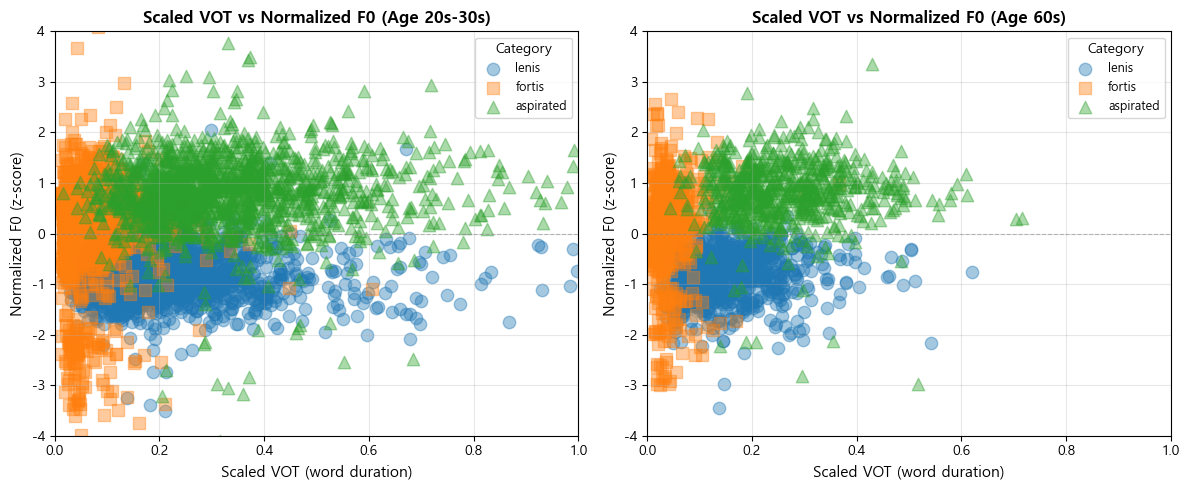


Standardized F0 by age group and phonation type:
                      count      mean       std       min       25%       50%  \
age_group phonation                                                             
20s-30s   aspirated  1487.0  0.818956  0.727104 -4.103728  0.444998  0.839332   
          lenis      1701.0 -0.759998  0.546402 -3.503996 -1.086175 -0.783148   
          tense      1602.0  0.046798  0.960663 -6.055730 -0.243135  0.172699   
60s       aspirated   656.0  0.848551  0.643612 -2.974917  0.514358  0.867016   
          lenis       774.0 -0.816131  0.489641 -3.447374 -1.104948 -0.772222   
          tense       714.0  0.105092  0.972685 -3.006083 -0.236602  0.185206   

                          75%       max  
age_group phonation                      
20s-30s   aspirated  1.212171  7.002574  
          lenis     -0.457773  6.629211  
          tense      0.571082  4.415078  
60s       aspirated  1.215597  5.724777  
          lenis     -0.468869  0.461491  
       

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\3630058368.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(stops_df.groupby(['age_group', 'phonation'])['normed_f0'].describe())


In [59]:
# Create age groups
stops_df['age_group'] = pd.cut(stops_df['age'], bins=[0, 60, 100], labels=['20s-30s', '60s'])

# Define consistent colors and markers for each phonation type
phonation_order = ['lenis', 'tense', 'aspirated']
colors = {'lenis': '#1f77b4', 'tense': '#ff7f0e', 'aspirated': '#2ca02c'}
markers = {'lenis': 'o', 'tense': 's', 'aspirated': '^'}
label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}  # For legend display

# Get overall x and y axis ranges for consistency
vot_min, vot_max = stops_df['scaled_vot'].min(), stops_df['scaled_vot'].max()
vot_range = vot_max - vot_min
vot_padding = vot_range * 0.05  # 5% padding

# Plot by age group
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, age_group in enumerate(['20s-30s', '60s']):
    df_age = stops_df[stops_df['age_group'] == age_group]
    
    # Plot each phonation type separately to ensure consistent styling
    for phonation in phonation_order:
        df_phon = df_age[df_age['phonation'] == phonation]
        axes[idx].scatter(df_phon['scaled_vot'], df_phon['normed_f0'], 
                         c=colors[phonation], marker=markers[phonation], 
                         s=80, alpha=0.4, label=label_map[phonation])
    
    axes[idx].set_title(f'Scaled VOT vs Normalized F0 (Age {age_group})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Scaled VOT (word duration)', fontsize=11)
    axes[idx].set_ylabel('Normalized F0 (z-score)', fontsize=11)
    axes[idx].legend(title='Category', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[idx].set_xlim(0, 1)
    axes[idx].set_ylim(-4, 4)
    
    print(f"\nAge group {age_group}: {len(df_age)} observations")

plt.tight_layout()
plt.savefig("x-scaled-vot-y-normed-f0-by-age-young-old.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nStandardized F0 by age group and phonation type:")
print(stops_df.groupby(['age_group', 'phonation'])['normed_f0'].describe())

20s-30s Male: 1609 observations
20s-30s Female: 3181 observations
60s Male: 648 observations
60s Female: 1106 observations


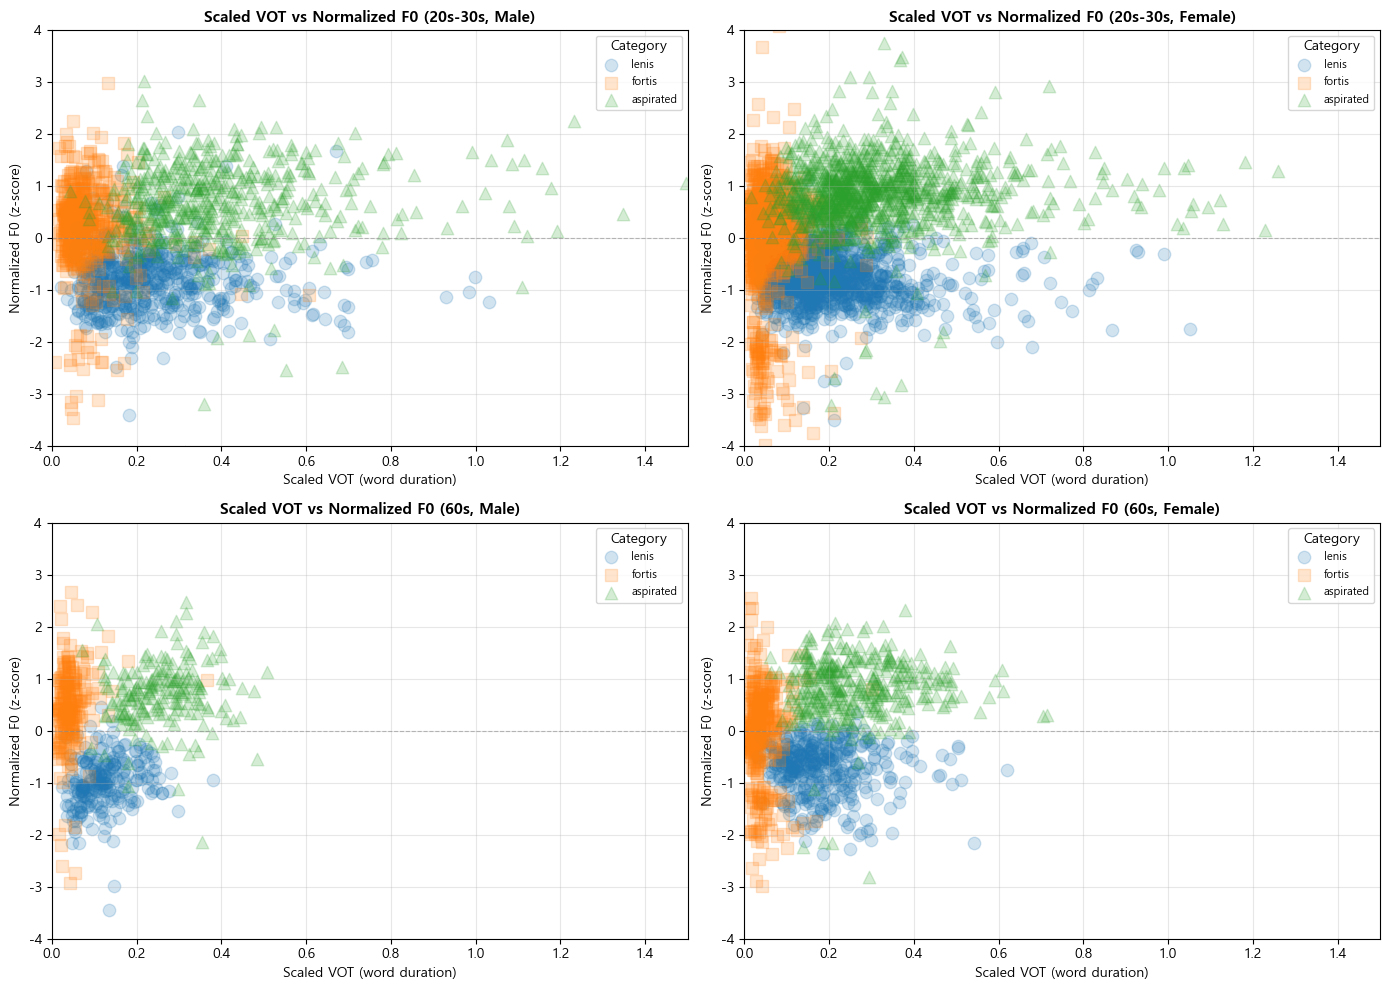


Normalized F0 by age group, gender, and phonation type:
                             count      mean       std       min       25%  \
age_group gender phonation                                                   
20s-30s   Female aspirated   987.0  0.876488  0.656901 -3.214885  0.531898   
                 lenis      1128.0 -0.746187  0.484683 -3.503996 -1.048931   
                 tense      1066.0 -0.021946  1.006994 -6.055730 -0.294864   
          Male   aspirated   500.0  0.705388  0.838008 -4.103728  0.216873   
                 lenis       573.0 -0.787188  0.650649 -3.389888 -1.200479   
                 tense       536.0  0.183516  0.845566 -4.479716 -0.150982   
60s       Female aspirated   347.0  0.855953  0.644409 -2.813391  0.517062   
                 lenis       397.0 -0.720319  0.491657 -2.362378 -0.980763   
                 tense       362.0 -0.030522  1.048729 -2.976638 -0.456401   
          Male   aspirated   193.0  0.718003  0.601102 -2.132902  0.371070   
       

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1746946456.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(stops_df.groupby(['age_group', 'gender', 'phonation'])['normed_f0'].describe())


In [60]:
# Plot by age group and gender
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

age_gender_combinations = [
    ('20s-30s', 'Male'),
    ('20s-30s', 'Female'),
    ('60s', 'Male'),
    ('60s', 'Female')
]

for idx, (age_group, gender) in enumerate(age_gender_combinations):
    row = idx // 2
    col = idx % 2
    
    df_subset = stops_df[(stops_df['age_group'] == age_group) & (stops_df['gender'] == gender)]
    
    # Plot each phonation type separately to ensure consistent styling
    for phonation in phonation_order:
        df_phon = df_subset[df_subset['phonation'] == phonation]
        axes[row, col].scatter(df_phon['scaled_vot'], df_phon['normed_f0'], 
                               c=colors[phonation], marker=markers[phonation], 
                               s=80, alpha=0.2, label=label_map[phonation])
    
    axes[row, col].set_title(f'Scaled VOT vs Normalized F0 ({age_group}, {gender})', fontsize=11, fontweight='bold')
    axes[row, col].set_xlabel('Scaled VOT (word duration)', fontsize=10)
    axes[row, col].set_ylabel('Normalized F0 (z-score)', fontsize=10)
    axes[row, col].legend(title='Category', fontsize=8)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[row, col].set_xlim(0, 1.5)
    axes[row, col].set_ylim(-4, 4)
    
    print(f"{age_group} {gender}: {len(df_subset)} observations")

plt.tight_layout()
plt.savefig("scaled-vot-normed-f0-by-age-gender.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nNormalized F0 by age group, gender, and phonation type:")
print(stops_df.groupby(['age_group', 'gender', 'phonation'])['normed_f0'].describe())

Youngest participant: ID 215, Age 20
Number of observations: 135


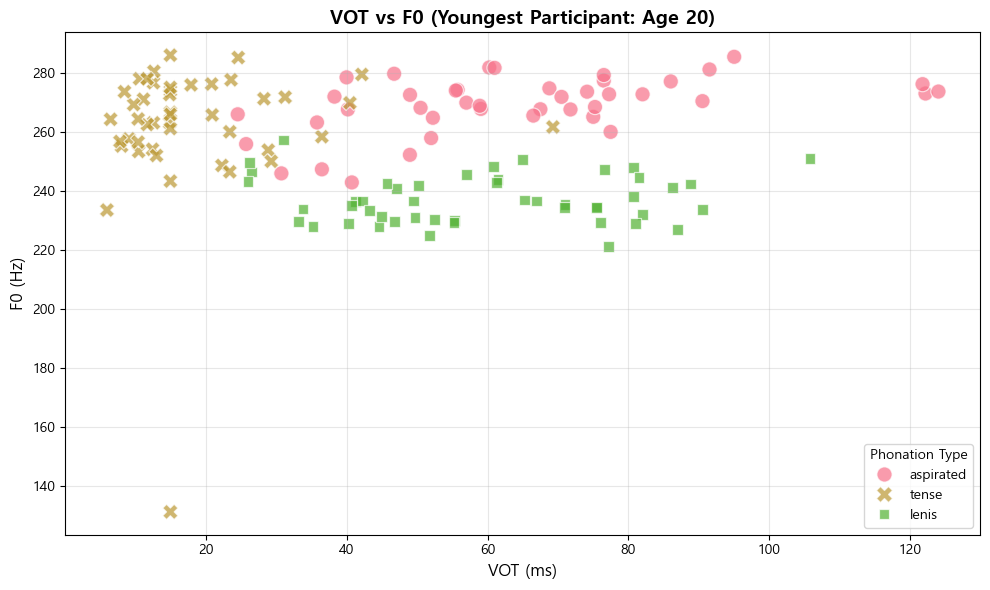


F0 by phonation type (youngest participant):
           count        mean        std         min         25%         50%  \
phonation                                                                     
aspirated   42.0  269.268736   9.733455  242.936425  265.690630  271.210592   
lenis       48.0  237.176127   8.026399  221.241808  230.193198  235.864373   
tense       45.0  262.094029  23.063197  131.281800  256.598275  264.440760   

                  75%         max  
phonation                          
aspirated  274.698224  285.509151  
lenis      242.906516  257.291832  
tense      273.972586  286.063785  


In [15]:
# Find the youngest participant
youngest_age = stops_df['age'].min()
youngest_participants = stops_df[stops_df['age'] == youngest_age]['prolific_id'].unique()
youngest_participant = youngest_participants[0]

print(f"Youngest participant: ID {youngest_participant}, Age {youngest_age}")
print(f"Number of observations: {len(stops_df[stops_df['prolific_id'] == youngest_participant])}")

# Filter data for the youngest participant
youngest_df = stops_df[stops_df['prolific_id'] == youngest_participant].copy()

# Plot VOT vs F0 for youngest participant
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=youngest_df, x='vot', y='f0', hue='phonation', 
                style='phonation', s=120, alpha=0.7, ax=ax)
ax.set_title(f'VOT vs F0 (Youngest Participant: Age {youngest_age})', fontsize=14, fontweight='bold')
ax.set_xlabel('VOT (ms)', fontsize=12)
ax.set_ylabel('F0 (Hz)', fontsize=12)
ax.legend(title='Phonation Type', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nF0 by phonation type (youngest participant):")
print(youngest_df.groupby('phonation')['f0'].describe())

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1335028353.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1335028353.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=9)
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1335028353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1335028353.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

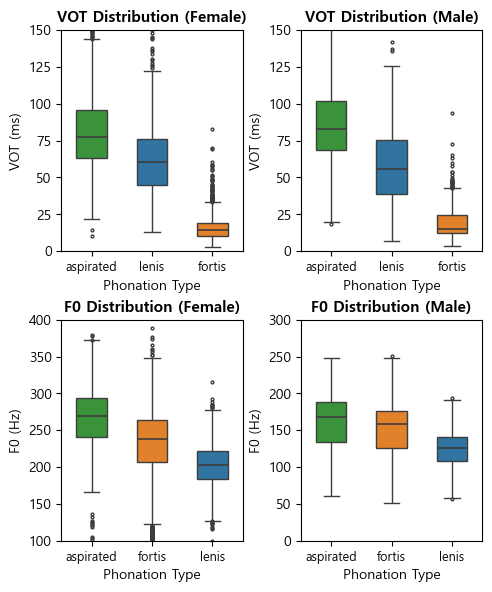

In [61]:
# 2. VOT/F0 분포 (by phonation type, female vs male, 2x2 subplot, gender=col, VOT/F0=row, y축 통일, F0 x축 순서 변경, F0 y축 수동 설정, VOT y축 150 고정)
phonation_label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}
phonation_order_vot = ['aspirated', 'lenis', 'tense']
phonation_order_f0 = ['aspirated', 'tense', 'lenis']
phonation_colors = {'lenis': '#1f77b4', 'tense': '#ff7f0e', 'aspirated': '#2ca02c'}  # blue, orange, green

# label 컬럼 생성 (tense→fortis)
stops_df['phonation_label'] = stops_df['phonation'].map(phonation_label_map)

# 전체적으로 그래프 크기와 박스 간격 축소
fig, axes = plt.subplots(2, 2, figsize=(5, 6))  # 크기 축소

# 박스 너비와 간격 조정: width=0.3, dodge=False로 박스 간격 최소화
# 위: VOT (좌: Female, 우: Male, y축 0~150 고정)
sns.boxplot(
    data=stops_df[stops_df['gender']=='Female'],
    x='phonation', y='vot', order=phonation_order_vot,
    palette=[phonation_colors[p] for p in phonation_order_vot],
    ax=axes[0,0],
    width=0.5,
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2)
    )
axes[0,0].set_title('VOT Distribution (Female)', fontsize=11, fontweight='bold')
axes[0,0].set_xlabel('Phonation Type', fontsize=10)
axes[0,0].set_ylabel('VOT (ms)', fontsize=10)
axes[0,0].set_ylim(0, 150)
axes[0,0].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=9)

sns.boxplot(
    data=stops_df[stops_df['gender']=='Male'],
    x='phonation', y='vot', order=phonation_order_vot,
    palette=[phonation_colors[p] for p in phonation_order_vot],
    ax=axes[0,1],
    width=0.5,
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2)
    )
axes[0,1].set_title('VOT Distribution (Male)', fontsize=11, fontweight='bold')
axes[0,1].set_xlabel('Phonation Type', fontsize=10)
axes[0,1].set_ylabel('VOT (ms)', fontsize=10)
axes[0,1].set_ylim(0, 150)
axes[0,1].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=9)

# 아래: F0 (좌: Female, 우: Male, y축 수동, x축 aspirated-fortis-lenis)
sns.boxplot(
    data=stops_df[stops_df['gender']=='Female'],
    x='phonation', y='f0', order=phonation_order_f0,
    palette=[phonation_colors[p] for p in phonation_order_f0],
    ax=axes[1,0],
    width=0.5,
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2)
    )
axes[1,0].set_title('F0 Distribution (Female)', fontsize=11, fontweight='bold')
axes[1,0].set_xlabel('Phonation Type', fontsize=10)
axes[1,0].set_ylabel('F0 (Hz)', fontsize=10)
axes[1,0].set_ylim(100, 400)
axes[1,0].set_xticklabels([phonation_label_map[p] for p in phonation_order_f0], fontsize=9)

sns.boxplot(
    data=stops_df[stops_df['gender']=='Male'],
    x='phonation', y='f0', order=phonation_order_f0,
    palette=[phonation_colors[p] for p in phonation_order_f0],
    ax=axes[1,1],
    width=0.5,
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2)
    )
axes[1,1].set_title('F0 Distribution (Male)', fontsize=11, fontweight='bold')
axes[1,1].set_xlabel('Phonation Type', fontsize=10)
axes[1,1].set_ylabel('F0 (Hz)', fontsize=10)
axes[1,1].set_ylim(0, 300)
axes[1,1].set_xticklabels([phonation_label_map[p] for p in phonation_order_f0], fontsize=9)

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
plt.savefig("vot-and-f0-by-phonation-and-gender.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1506895371.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1506895371.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=9)
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1506895371.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1506895371.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

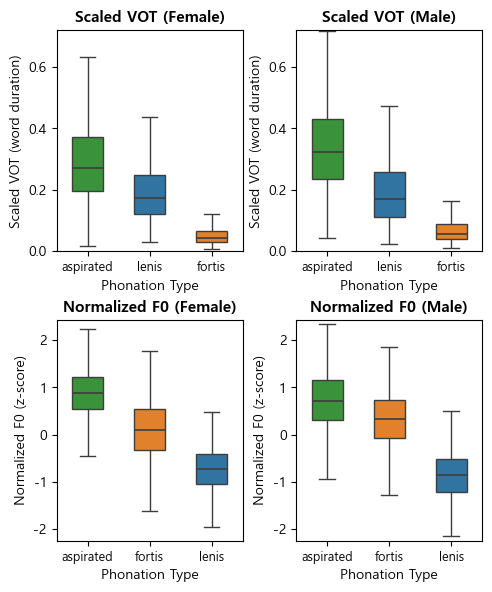

In [62]:
# 2-2. Scaled VOT/F0 분포 (female vs male, 2x2 subplot, gender=col, scaled_vot/normed_f0=row, 좌우 y축 범위 일치)
phonation_label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}
phonation_order_vot = ['aspirated', 'lenis', 'tense']
phonation_order_f0 = ['aspirated', 'tense', 'lenis']
phonation_colors = {'lenis': '#1f77b4', 'tense': '#ff7f0e', 'aspirated': '#2ca02c'}  # blue, orange, green

# label 컬럼 생성 (tense→fortis)
stops_df['phonation_label'] = stops_df['phonation'].map(phonation_label_map)

fig, axes = plt.subplots(2, 2, figsize=(5, 6))  # CELL 16과 동일한 플롯 크기

# 각 row별로 박스플롯의 IQR(박스+수염)만 커버하는 y축 범위 계산 함수
def get_boxplot_range(data, y, x, order):
    q1 = data.groupby(x)[y].quantile(0.25).reindex(order)
    q3 = data.groupby(x)[y].quantile(0.75).reindex(order)
    iqr = q3 - q1
    whisker_low = (q1 - 1.5 * iqr).min()
    whisker_high = (q3 + 1.5 * iqr).max()
    return whisker_low, whisker_high

# 위: scaled_vot (좌: Female, 우: Male)
vot_low_f, vot_high_f = get_boxplot_range(stops_df[stops_df['gender']=='Female'], 'scaled_vot', 'phonation', phonation_order_vot)
vot_low_m, vot_high_m = get_boxplot_range(stops_df[stops_df['gender']=='Male'], 'scaled_vot', 'phonation', phonation_order_vot)
vot_min = min(vot_low_f, vot_low_m)
vot_max = max(vot_high_f, vot_high_m)

sns.boxplot(
    data=stops_df[stops_df['gender']=='Female'],
    x='phonation', y='scaled_vot', order=phonation_order_vot,
    palette=[phonation_colors[p] for p in phonation_order_vot],
    ax=axes[0,0],
    width=0.5,  # CELL 16과 동일한 박스 폭
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2),
    showfliers=False
    )
axes[0,0].set_title('Scaled VOT (Female)', fontsize=11, fontweight='bold')
axes[0,0].set_xlabel('Phonation Type', fontsize=10)
axes[0,0].set_ylabel('Scaled VOT (word duration)', fontsize=10)
axes[0,0].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=9)
axes[0,0].set_ylim(0, vot_max)

sns.boxplot(
    data=stops_df[stops_df['gender']=='Male'],
    x='phonation', y='scaled_vot', order=phonation_order_vot,
    palette=[phonation_colors[p] for p in phonation_order_vot],
    ax=axes[0,1],
    width=0.5,  # CELL 16과 동일한 박스 폭
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2),
    showfliers=False
    )
axes[0,1].set_title('Scaled VOT (Male)', fontsize=11, fontweight='bold')
axes[0,1].set_xlabel('Phonation Type', fontsize=10)
axes[0,1].set_ylabel('Scaled VOT (word duration)', fontsize=10)
axes[0,1].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=9)
axes[0,1].set_ylim(0, vot_max)

# 아래: normalized_f0 (좌: Female, 우: Male)
f0_low_f, f0_high_f = get_boxplot_range(stops_df[stops_df['gender']=='Female'], 'normed_f0', 'phonation', phonation_order_f0)
f0_low_m, f0_high_m = get_boxplot_range(stops_df[stops_df['gender']=='Male'], 'normed_f0', 'phonation', phonation_order_f0)
f0_min = min(f0_low_f, f0_low_m)
f0_max = max(f0_high_f, f0_high_m)

sns.boxplot(
    data=stops_df[stops_df['gender']=='Female'],
    x='phonation', y='normed_f0', order=phonation_order_f0,
    palette=[phonation_colors[p] for p in phonation_order_f0],
    ax=axes[1,0],
    width=0.5,  # CELL 16과 동일한 박스 폭
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2),
    showfliers=False
    )
axes[1,0].set_title('Normalized F0 (Female)', fontsize=11, fontweight='bold')
axes[1,0].set_xlabel('Phonation Type', fontsize=10)
axes[1,0].set_ylabel('Normalized F0 (z-score)', fontsize=10)
axes[1,0].set_xticklabels([phonation_label_map[p] for p in phonation_order_f0], fontsize=9)
axes[1,0].set_ylim(f0_min, f0_max)

sns.boxplot(
    data=stops_df[stops_df['gender']=='Male'],
    x='phonation', y='normed_f0', order=phonation_order_f0,
    palette=[phonation_colors[p] for p in phonation_order_f0],
    ax=axes[1,1],
    width=0.5,  # CELL 16과 동일한 박스 폭
    dodge=False,
    boxprops=dict(linewidth=1),
    medianprops=dict(linewidth=1.2),
    showcaps=True,
    flierprops=dict(marker='o', markersize=2),
    showfliers=False
    )
axes[1,1].set_title('Normalized F0 (Male)', fontsize=11, fontweight='bold')
axes[1,1].set_xlabel('Phonation Type', fontsize=10)
axes[1,1].set_ylabel('Normalized F0 (z-score)', fontsize=10)
axes[1,1].set_xticklabels([phonation_label_map[p] for p in phonation_order_f0], fontsize=9)
axes[1,1].set_ylim(f0_min, f0_max)

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)  # CELL 16과 동일한 간격 설정
plt.savefig("scaled-vot-and-normed-f0-by-phonation-and-gender.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_vot[row_idx, col_idx].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=8)
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks

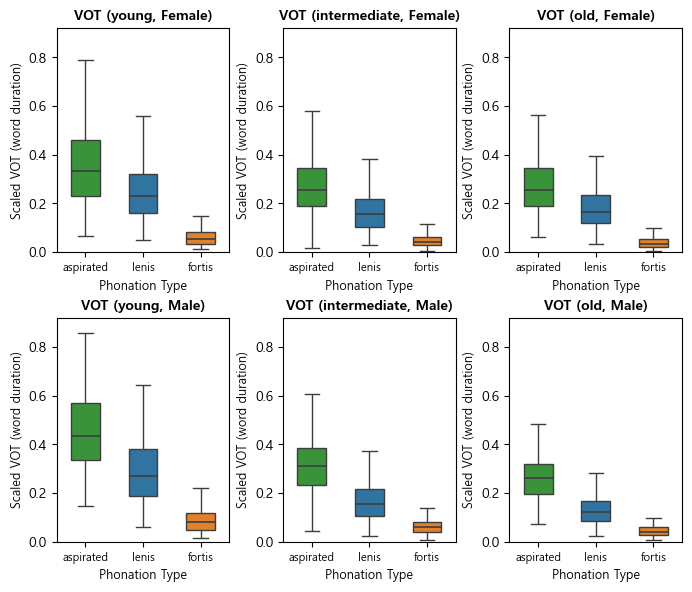

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_f0[row_idx, col_idx].set_xticklabels([phonation_label_map[p] for p in phonation_order_f0], fontsize=8)
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\329323573.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks()

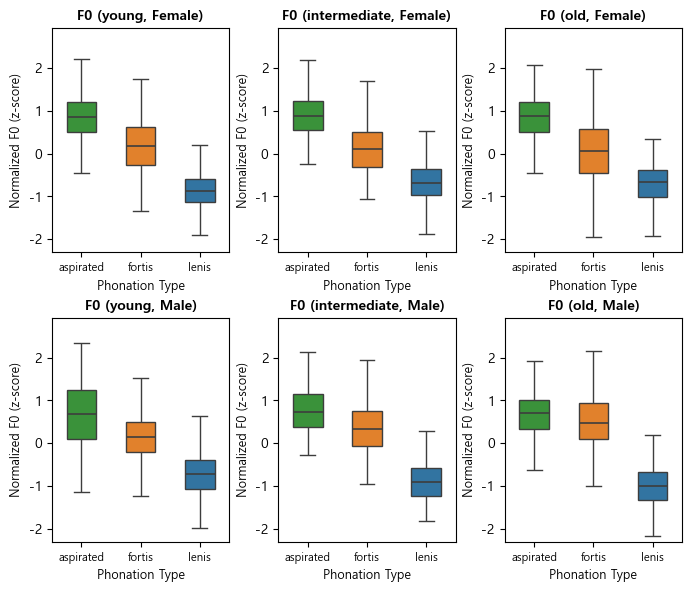

In [63]:
# 2-4. Normalized VOT/F0 분포 (나이대별, FEMALE/MALE 행 분리, VOT/F0 각각 별도 그래프)
phonation_label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}
phonation_order_vot = ['aspirated', 'lenis', 'tense']
phonation_order_f0 = ['aspirated', 'tense', 'lenis']
phonation_colors = {'lenis': '#1f77b4', 'tense': '#ff7f0e', 'aspirated': '#2ca02c'}  # blue, orange, green

# age_group 컬럼 생성 (20-30대, 40-50대, 60대 이상)
stops_df['age'] = pd.to_numeric(stops_df['age'], errors='coerce')
age_bins = [0, 39, 59, 120]
age_labels = ['young', 'intermediate', 'old']
stops_df['age_group3'] = pd.cut(stops_df['age'], bins=age_bins, labels=age_labels, right=True)

gender_labels = ['Female', 'Male']  # FEMALE 위, MALE 아래

# VOT 그래프 (2행 3열, 위: Female, 아래: Male)
fig_vot, axes_vot = plt.subplots(2, 3, figsize=(7, 6))

def get_boxplot_range(data, y, x, order):
    q1 = data.groupby(x)[y].quantile(0.25).reindex(order)
    q3 = data.groupby(x)[y].quantile(0.75).reindex(order)
    iqr = q3 - q1
    whisker_low = (q1 - 1.5 * iqr).min()
    whisker_high = (q3 + 1.5 * iqr).max()
    return whisker_low, whisker_high

vot_lows = []
vot_highs = []
for gender in gender_labels:
    for age_group in age_labels:
        df_sub = stops_df[(stops_df['age_group3'] == age_group) & (stops_df['gender'] == gender)]
        low, high = get_boxplot_range(df_sub, 'scaled_vot', 'phonation', phonation_order_vot)
        vot_lows.append(low)
        vot_highs.append(high)
vot_min = min(vot_lows)
vot_max = max(vot_highs)

for col_idx, age_group in enumerate(age_labels):
    for row_idx, gender in enumerate(gender_labels):
        df_sub = stops_df[(stops_df['age_group3'] == age_group) & (stops_df['gender'] == gender)]
        sns.boxplot(
            data=df_sub,
            x='phonation', y='scaled_vot', order=phonation_order_vot,
            palette=[phonation_colors[p] for p in phonation_order_vot],
            ax=axes_vot[row_idx, col_idx],
            width=0.5,
            dodge=False,
            boxprops=dict(linewidth=1),
            medianprops=dict(linewidth=1.2),
            showcaps=True,
            flierprops=dict(marker='o', markersize=2),
            showfliers=False
        )
        axes_vot[row_idx, col_idx].set_title(f'VOT ({age_group}, {gender})', fontsize=10, fontweight='bold')
        axes_vot[row_idx, col_idx].set_xlabel('Phonation Type', fontsize=9)
        axes_vot[row_idx, col_idx].set_ylabel('Scaled VOT (word duration)', fontsize=9)
        axes_vot[row_idx, col_idx].set_xticklabels([phonation_label_map[p] for p in phonation_order_vot], fontsize=8)
        axes_vot[row_idx, col_idx].set_ylim(0, vot_max)

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
plt.savefig("scaled-vot-by-phonation-age-gender.png", dpi=300, bbox_inches='tight')
plt.show()

# F0 그래프 (2행 3열, 위: Female, 아래: Male)
fig_f0, axes_f0 = plt.subplots(2, 3, figsize=(7, 6))

f0_lows = []
f0_highs = []
for gender in gender_labels:
    for age_group in age_labels:
        df_sub = stops_df[(stops_df['age_group3'] == age_group) & (stops_df['gender'] == gender)]
        low, high = get_boxplot_range(df_sub, 'normed_f0', 'phonation', phonation_order_f0)
        f0_lows.append(low)
        f0_highs.append(high)
f0_min = min(f0_lows)
f0_max = max(f0_highs)

for col_idx, age_group in enumerate(age_labels):
    for row_idx, gender in enumerate(gender_labels):
        df_sub = stops_df[(stops_df['age_group3'] == age_group) & (stops_df['gender'] == gender)]
        sns.boxplot(
            data=df_sub,
            x='phonation', y='normed_f0', order=phonation_order_f0,
            palette=[phonation_colors[p] for p in phonation_order_f0],
            ax=axes_f0[row_idx, col_idx],
            width=0.5,
            dodge=False,
            boxprops=dict(linewidth=1),
            medianprops=dict(linewidth=1.2),
            showcaps=True,
            flierprops=dict(marker='o', markersize=2),
            showfliers=False
        )
        axes_f0[row_idx, col_idx].set_title(f'F0 ({age_group}, {gender})', fontsize=10, fontweight='bold')
        axes_f0[row_idx, col_idx].set_xlabel('Phonation Type', fontsize=9)
        axes_f0[row_idx, col_idx].set_ylabel('Normalized F0 (z-score)', fontsize=9)
        axes_f0[row_idx, col_idx].set_xticklabels([phonation_label_map[p] for p in phonation_order_f0], fontsize=8)
        axes_f0[row_idx, col_idx].set_ylim(f0_min, f0_max)

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
plt.savefig("normed-f0-by-phonation-age-gender.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\516743338.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\516743338.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels([phonation_label_map[p] for p in phonation_order], fontsize=8)
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\516743338.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\516743338.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

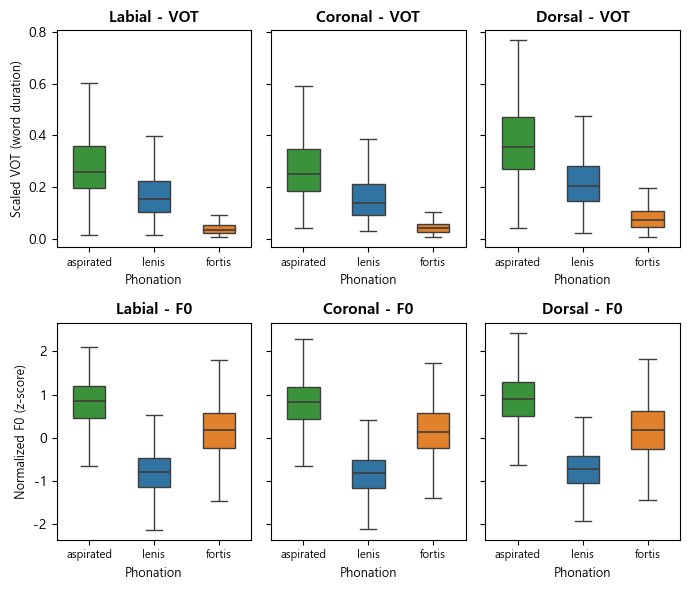

In [64]:
# Normalized VOT/F0 분포 (POA별, 박스플랏, 2행 3열 서브플롯)
import matplotlib.pyplot as plt
import seaborn as sns

poa_labels = ['labial', 'coronal', 'dorsal']
phonation_label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}
phonation_order = ['aspirated', 'lenis', 'tense']
phonation_colors = {'lenis': '#1f77b4', 'tense': '#ff7f0e', 'aspirated': '#2ca02c'}
y_vars = ['scaled_vot', 'normed_f0']
y_labels = ['Scaled VOT (word duration)', 'Normalized F0 (z-score)']

fig, axes = plt.subplots(2, 3, figsize=(7, 6), sharey='row')
for col, poa in enumerate(poa_labels):
    for row, (yvar, ylabel) in enumerate(zip(y_vars, y_labels)):
        data = stops_df[stops_df['poa'] == poa]
        sns.boxplot(
            data=data,
            x='phonation',
            y=yvar,
            order=phonation_order,
            palette=[phonation_colors[p] for p in phonation_order],
            ax=axes[row, col],
            width=0.5,
            dodge=False,
            boxprops=dict(linewidth=1),
            medianprops=dict(linewidth=1.2),
            showcaps=True,
            flierprops=dict(marker='o', markersize=2),
            showfliers=False
        )
        axes[row, col].set_title(f'{poa.capitalize()} - {ylabel.split()[1]}', fontsize=11, fontweight='bold')
        axes[row, col].set_xlabel('Phonation', fontsize=9)
        if col == 0:
            axes[row, col].set_ylabel(ylabel, fontsize=9)
        else:
            axes[row, col].set_ylabel('')
        axes[row, col].set_xticklabels([phonation_label_map[p] for p in phonation_order], fontsize=8)
plt.tight_layout()
plt.savefig("scaled-vot-and-normed-f0-by-poa-and-phonation.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1144040039.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1144040039.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels([p.capitalize() for p in poa_order], fontsize=8)
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1144040039.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\1144040039.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator

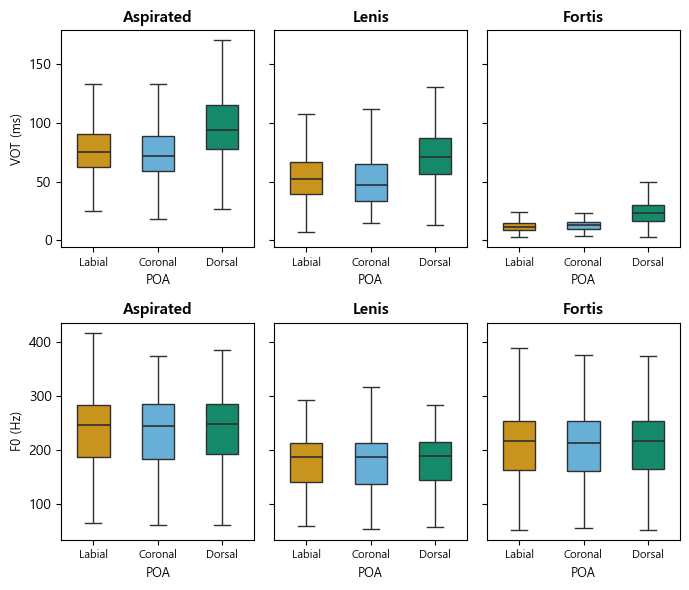

In [65]:
# Normalized VOT/F0 분포 (Phonation별, 박스플랏, 2행 3열 서브플롯)
import matplotlib.pyplot as plt
import seaborn as sns

poa_labels = ['labial', 'coronal', 'dorsal']
poa_order = poa_labels  # x축 순서
# Colorblind-friendly palette (Color Universal Design, e.g., Okabe & Ito)
poa_palette = {'labial': '#E69F00', 'coronal': '#56B4E9', 'dorsal': '#009E73'}  # orange, sky blue, bluish green
phonation_label_map = {'lenis': 'lenis', 'tense': 'fortis', 'aspirated': 'aspirated'}
phonation_order = ['aspirated', 'lenis', 'tense']
y_vars = ['vot', 'f0']
y_labels = ['VOT (ms)', 'F0 (Hz)']

fig, axes = plt.subplots(2, 3, figsize=(7, 6), sharey='row')
for col, phonation in enumerate(phonation_order):
    for row, (yvar, ylabel) in enumerate(zip(y_vars, y_labels)):
        data = stops_df[stops_df['phonation'] == phonation]
        sns.boxplot(
            data=data,
            x='poa',
            y=yvar,
            order=poa_order,
            palette=[poa_palette[p] for p in poa_order],
            ax=axes[row, col],
            width=0.5,
            dodge=False,
            boxprops=dict(linewidth=1),
            medianprops=dict(linewidth=1.2),
            showcaps=True,
            flierprops=dict(marker='o', markersize=2),
            showfliers=False
        )
        axes[row, col].set_title(f"{phonation_label_map[phonation].capitalize()}", fontsize=11, fontweight='bold')
        axes[row, col].set_xlabel('POA', fontsize=9)
        if col == 0:
            axes[row, col].set_ylabel(ylabel, fontsize=9)
        else:
            axes[row, col].set_ylabel('')
        axes[row, col].set_xticklabels([p.capitalize() for p in poa_order], fontsize=8)

plt.tight_layout()
plt.savefig("vot-and-f0-by-phonation-and-poa.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\3930572540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stops_df, x='prolific_id', y='f0', order=participants_sorted_f0, palette='mako', ax=axes[0])
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\3930572540.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stops_df, x='prolific_id', y='vot', order=participants_sorted_vot, palette='viridis', ax=axes[1])


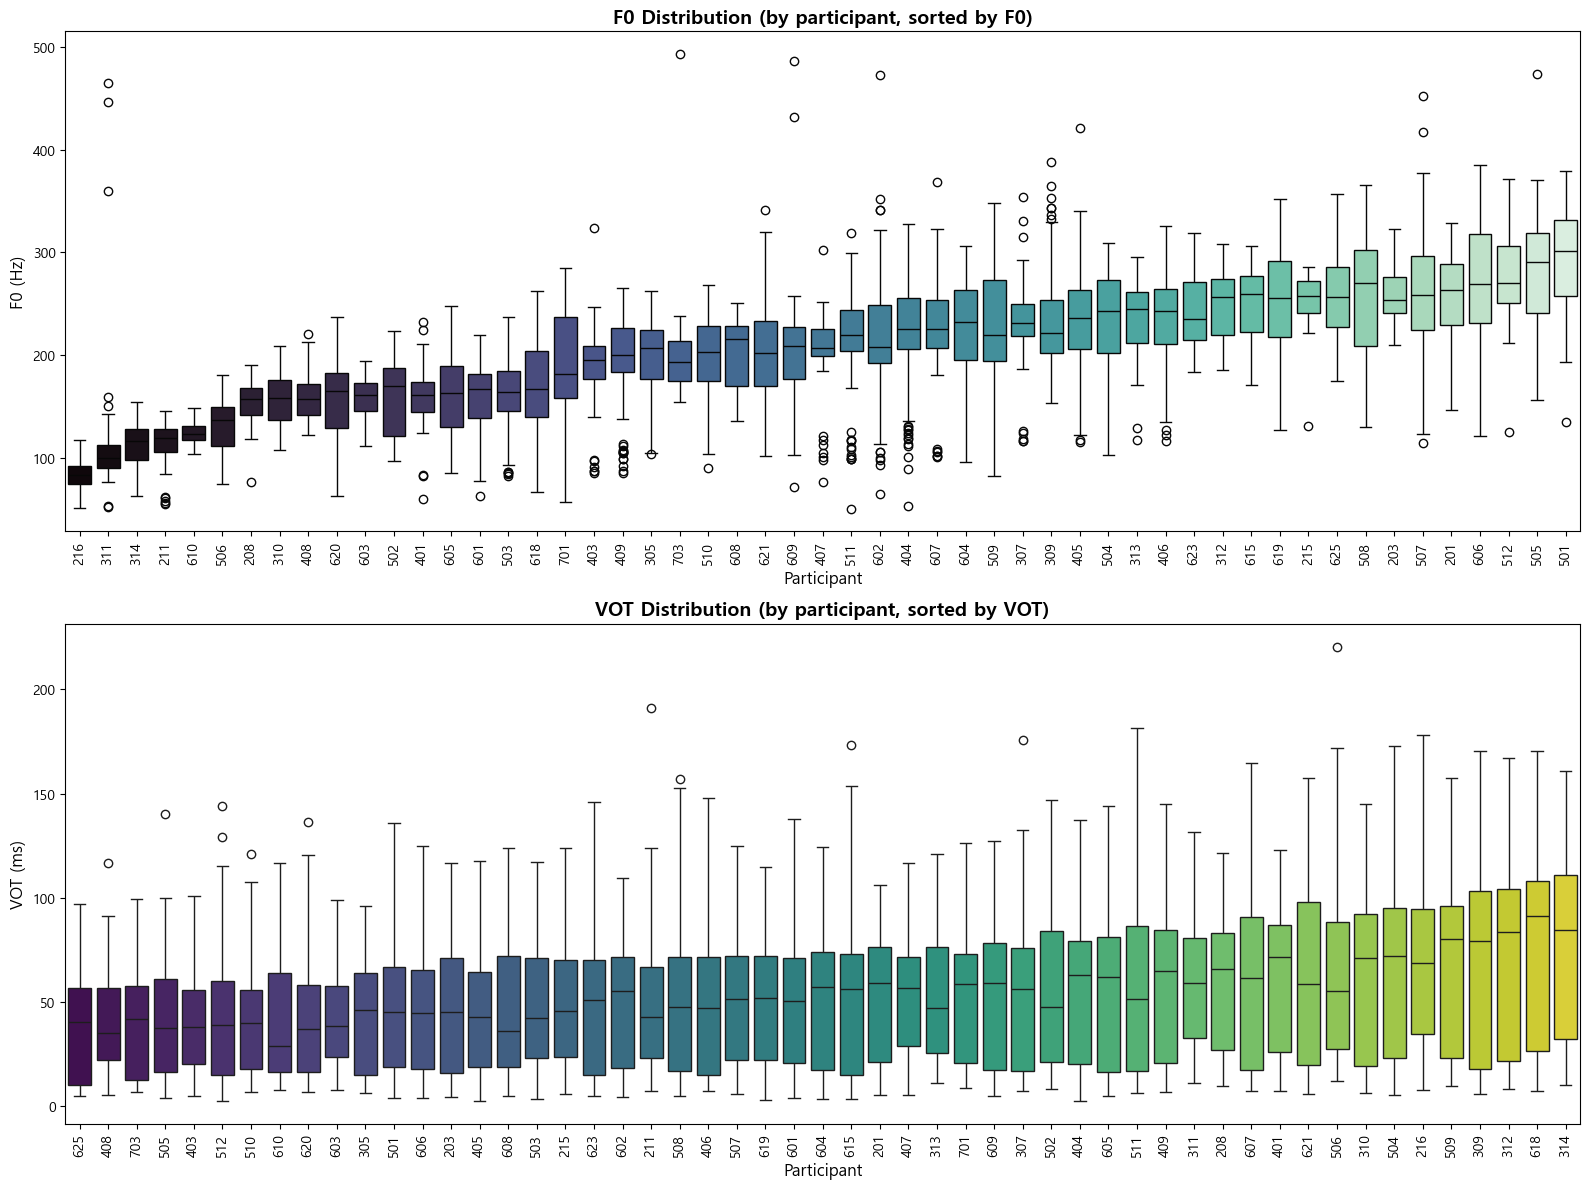

In [66]:
# F0 & VOT - 참가자별/나이별 (한 그래프, 4개 subplot, 세로 배치)
# 참가자(prolific_id)별로 Y값(첫번째: f0, 두번째: VOT) 기준 오름차순 정렬

def get_sorted_participants_by_y(stops_df, y_col):
    # 각 참가자별 y_col의 평균값 기준 오름차순 정렬
    means = stops_df.groupby('prolific_id')[y_col].mean().sort_values()
    return means.index.tolist()

participants_sorted_f0 = get_sorted_participants_by_y(stops_df, 'f0')
participants_sorted_vot = get_sorted_participants_by_y(stops_df, 'vot')
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# F0 by participant (f0 평균 오름차순)
sns.boxplot(data=stops_df, x='prolific_id', y='f0', order=participants_sorted_f0, palette='mako', ax=axes[0])
axes[0].set_title('F0 Distribution (by participant, sorted by F0)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Participant', fontsize=12)
axes[0].set_ylabel('F0 (Hz)', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# VOT by participant (vot 평균 오름차순)
sns.boxplot(data=stops_df, x='prolific_id', y='vot', order=participants_sorted_vot, palette='viridis', ax=axes[1])
axes[1].set_title('VOT Distribution (by participant, sorted by VOT)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Participant', fontsize=12)
axes[1].set_ylabel('VOT (ms)', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.savefig("f0-and-vot-by-participant.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\2341647213.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hanpe\AppData\Local\Temp\ipykernel_3488\2341647213.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


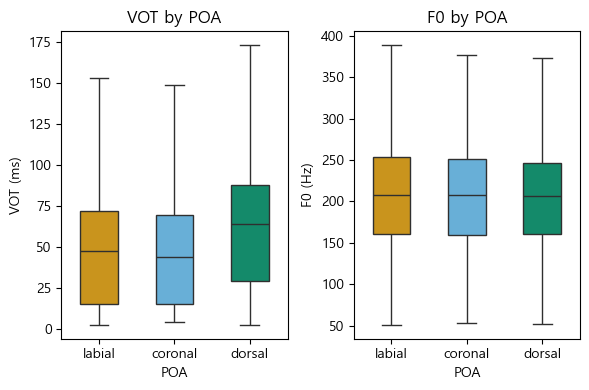

In [68]:
# POA별 VOT, F0 박스 그래프 (2개 subplot, x축: poa, y축: vot/f0, color-blind friendly 팔레트)
import matplotlib.pyplot as plt
import seaborn as sns

# Color-blind friendly palette (Color Universal Design, e.g., Okabe-Ito)
poa_order = ["labial", "coronal", "dorsal"]
poa_palette = {"labial": "#E69F00", "coronal": "#56B4E9", "dorsal": "#009E73"}  # Okabe-Ito colors

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# 첫번째 subplot: VOT
sns.boxplot(
    data=stops_df,
    x="poa",
    y="vot",
    order=poa_order,
    ax=axes[0],
    palette=poa_palette,
    width=0.5,  # 박스 너비 줄임
    showfliers=False  # 이상치(아웃라이어) 표시 제거
)
axes[0].set_title("VOT by POA")
axes[0].set_xlabel("POA")
axes[0].set_ylabel("VOT (ms)")

# 두번째 subplot: F0
sns.boxplot(
    data=stops_df,
    x="poa",
    y="f0",
    order=poa_order,
    ax=axes[1],
    palette=poa_palette,
    width=0.5,  # 박스 너비 줄임
    showfliers=False  # 이상치(아웃라이어) 표시 제거
)
axes[1].set_title("F0 by POA")
axes[1].set_xlabel("POA")
axes[1].set_ylabel("F0 (Hz)")

plt.tight_layout()
plt.savefig("vot-and-f0-by-poa.png", dpi=300, bbox_inches='tight')
plt.show()